## dataset link 

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

https://www.kaggle.com/datasets/sukritchatterjee/used-cars-dataset-cardekho

In [20]:
import pandas as pd
from pathlib import Path
import numpy as np


CACHE = "dataset/autovalu_mvp.parquet"
RAW = "dataset/vehicles.csv"


In [9]:
# Step 2 — Load dataset with caching (final cell)


if Path(CACHE).exists():
    # Fast path: load compact dataset
    df = pd.read_parquet(CACHE, engine="pyarrow")
    print("Loaded compact dataset:", df.shape)
else:
    # Slow path: load raw CSV and reduce it, then save
    df_raw = pd.read_csv(RAW, low_memory=False, on_bad_lines="skip")

    # Drop useless columns
    cols_to_drop = ["id","url","region_url","VIN","image_url","description",
                    "county","lat","long","posting_date"]
    df_reduced = df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns], errors="ignore").copy()

    # Convert to categories
    cat_cols = ["manufacturer","model","condition","cylinders","fuel","title_status",
                "transmission","drive","size","type","paint_color","state","region"]
    for c in cat_cols:
        if c in df_reduced.columns and df_reduced[c].dtype == "object":
            df_reduced[c] = df_reduced[c].astype("category")

    # Numeric compression
    if "year" in df_reduced.columns:
        df_reduced["year"] = pd.to_numeric(df_reduced["year"], errors="coerce").astype("Int16")
    if "price" in df_reduced.columns:
        df_reduced["price"] = pd.to_numeric(df_reduced["price"], errors="coerce", downcast="integer")
    if "odometer" in df_reduced.columns:
        df_reduced["odometer"] = pd.to_numeric(df_reduced["odometer"], errors="coerce", downcast="float")

    # Save compact version
    df_reduced.to_parquet(CACHE, engine="pyarrow", compression="zstd", index=False)
    df = df_reduced
    print("Built and cached compact dataset:", df.shape)


Loaded compact dataset: (426880, 16)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        426880 non-null  category
 1   price         426880 non-null  int64   
 2   year          425675 non-null  Int16   
 3   manufacturer  409234 non-null  category
 4   model         421603 non-null  category
 5   condition     252776 non-null  category
 6   cylinders     249202 non-null  category
 7   fuel          423867 non-null  category
 8   odometer      422480 non-null  float32 
 9   title_status  418638 non-null  category
 10  transmission  424324 non-null  category
 11  drive         296313 non-null  category
 12  size          120519 non-null  category
 13  type          334022 non-null  category
 14  paint_color   296677 non-null  category
 15  state         426880 non-null  category
dtypes: Int16(1), category(13), float32(1), int64(1)
memory usa

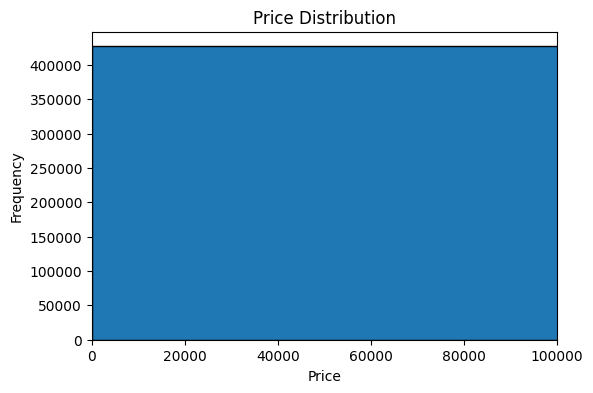

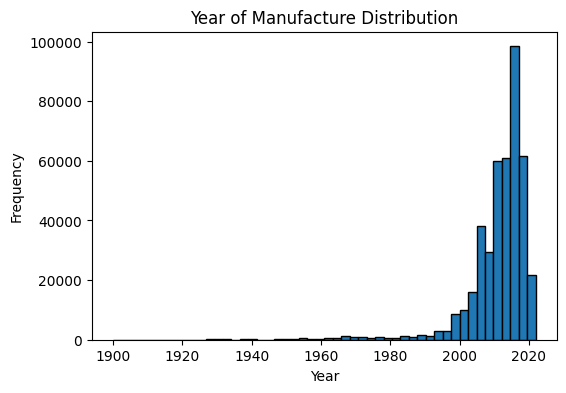

In [10]:
# Step 4 — Basic EDA (Exploratory Data Analysis)

import matplotlib.pyplot as plt

# 1. General info
print("DataFrame Info:")
print(df.info())
print("\nSummary statistics (numeric):")
print(df.describe())

# 2. Missing values summary (top 10)
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
print("\nMissing Values (Top 10):")
print(pd.DataFrame({"MissingCount": missing, "MissingPercent": missing_percent}).head(10))

# 3. Price distribution
plt.figure(figsize=(6,4))
df["price"].plot(kind="hist", bins=100, edgecolor="black")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.xlim(0, 100000)  # clip to focus on normal range
plt.show()

# 4. Year distribution
plt.figure(figsize=(6,4))
df["year"].dropna().astype(int).plot(kind="hist", bins=50, edgecolor="black")
plt.title("Year of Manufacture Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Step 5 — Data Cleaning


before = df.shape[0]

# 1. Filter price
df = df[(df["price"] >= 100) & (df["price"] <= 200000)]

# 2. Filter year
df = df[(df["year"].isna()) | ((df["year"] >= 1960) & (df["year"] <= 2025))]

# 3. Drop high-missing columns
drop_cols = ["size", "condition", "cylinders"]
df = df.drop(columns=drop_cols, errors="ignore")

after = df.shape[0]
removed = before - after
print(f"Removed rows: {removed} ({round(removed/before*100, 2)}%)")
print("Remaining shape:", df.shape)
print("Columns:", list(df.columns))


Removed rows: 38655 (9.06%)
Remaining shape: (388225, 13)
Columns: ['region', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']


In [12]:
# Step 6 — Feature Engineering & Train/Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define features and target
target = "price"
features = [col for col in df.columns if col != target]

X = df[features].copy()
y = df[target].copy()

# 2. Encode categorical columns
cat_cols = X.select_dtypes(include="category").columns
for c in cat_cols:
    X[c] = X[c].cat.codes  # converts categories to integer codes

# 3. Scale numerical columns
num_cols = ["odometer", "year"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Features:", X_train.columns.tolist())


Train shape: (310580, 12)
Test shape: (77645, 12)
Features: ['region', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']


In [ ]:
# Step 7 — Impute numeric NaNs and re-train linear models

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Impute numeric columns BEFORE modeling
num_cols = ["odometer", "year"]
imputer_num = SimpleImputer(strategy="median")
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Train Ridge Regression
ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"  MAE : {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R²  : {r2:.4f}\n")

evaluate(y_test, y_pred_lin, "Linear Regression")
evaluate(y_test, y_pred_ridge, "Ridge Regression")


Linear Regression Results:
  MAE : 9,405.26
  RMSE: 13,157.68
  R²  : 0.2384

Ridge Regression Results:
  MAE : 9,405.26
  RMSE: 13,157.68
  R²  : 0.2384



In [15]:
# Step 8 — Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# 1. Train model
rf = RandomForestRegressor(
    n_estimators=100,     # number of trees
    max_depth=None,       # let trees expand fully
    random_state=42,
    n_jobs=-1             # use all CPU cores
)
rf.fit(X_train, y_train)

# 2. Predict
y_pred_rf = rf.predict(X_test)

# 3. Evaluate
evaluate(y_test, y_pred_rf, "Random Forest Regressor")


Random Forest Regressor Results:
  MAE : 2,373.13
  RMSE: 5,463.48
  R²  : 0.8687



In [16]:
# Step 8.1 — Check Overfitting: Train vs Test performance

# Predictions on train set
y_pred_train = rf.predict(X_train)

# Evaluate on Train
print("Train Performance:")
evaluate(y_train, y_pred_train, "Random Forest (Train)")

# Evaluate on Test (already have y_pred_rf, but repeat for clarity)
print("Test Performance:")
evaluate(y_test, y_pred_rf, "Random Forest (Test)")


Train Performance:
Random Forest (Train) Results:
  MAE : 892.91
  RMSE: 2,080.70
  R²  : 0.9808

Test Performance:
Random Forest (Test) Results:
  MAE : 2,373.13
  RMSE: 5,463.48
  R²  : 0.8687



In [ ]:
# Step 9 — Cross-Validation with Random Forest

from sklearn.model_selection import cross_val_score, KFold

# Define model (with limited depth to reduce overfitting a bit)
rf_cv = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,          # limit depth for generalization
    random_state=42,
    n_jobs=-1
)

# 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_cv, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)

print("Cross-Validation R² scores:", scores)
print("Mean R²:", scores.mean())
print("Std R² :", scores.std())


Cross-Validation R² scores: [0.84708308 0.84209075 0.84604404 0.83605887 0.84443272]
Mean R²: 0.8431418936820683
Std R² : 0.003921628708214183


In [ ]:
# Step 9 (lite) — Faster Cross-Validation with Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

rf_cv = RandomForestRegressor(
    n_estimators=60,
    max_depth=18,
    min_samples_leaf=8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(rf_cv, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)
mae_scores = -cross_val_score(rf_cv, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)

print("CV R²:", np.round(r2_scores, 4), "| Mean:", r2_scores.mean().round(4), " Std:", r2_scores.std().round(4))
print("CV MAE:", np.round(mae_scores, 2),    "| Mean:", np.mean(mae_scores).round(2), " Std:", np.std(mae_scores).round(2))


CV R²: [0.7954 0.7935 0.7989] | Mean: 0.7959  Std: 0.0022
CV MAE: [3575.69 3548.44 3513.72] | Mean: 3545.95  Std: 25.36


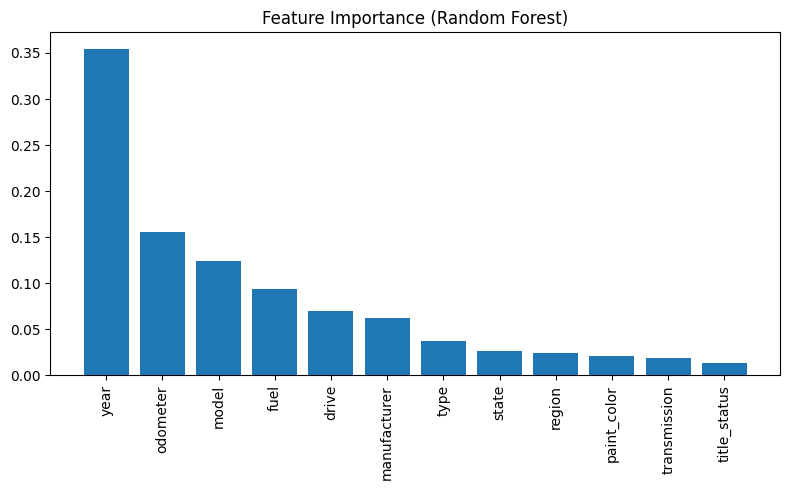

In [ ]:
# Step 10 — Feature Importance from Random Forest


# Train a final RF model (use the stronger one for feature importance)
rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train, y_train)

# Get importances
importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [22]:
# Step 11 — Target Encoding for 'model' and 'region' (fixed, no leakage)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1) Fresh split from df to avoid using prior encodings
target = "price"
X = df.drop(columns=[target]).copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 2) Target encoding helpers
def target_encode_fit_transform(train_col: pd.Series, y_train: pd.Series):
    """Return encoded train column + mapping + global mean."""
    mapping = y_train.groupby(train_col).mean()
    global_mean = y_train.mean()
    encoded = train_col.map(mapping).fillna(global_mean)
    return encoded, mapping, global_mean

def target_encode_transform(test_col: pd.Series, mapping: pd.Series, global_mean: float):
    """Apply mapping to test; unseen categories -> global mean."""
    return test_col.map(mapping).fillna(global_mean)

# 3) Apply target encoding to high-cardinality columns
for col in ["model", "region"]:
    # ensure categorical dtype
    if X_train[col].dtype != "category":
        X_train[col] = X_train[col].astype("category")
        X_test[col]  = X_test[col].astype("category")

    X_train[col], mapping, gmean = target_encode_fit_transform(X_train[col], y_train)
    X_test[col] = target_encode_transform(X_test[col], mapping, gmean)

# 4) Encode remaining categoricals with simple codes
cat_cols = X_train.select_dtypes(include="category").columns
for c in cat_cols:
    if c in ["model", "region"]:
        continue
    X_train[c] = X_train[c].cat.codes
    X_test[c]  = X_test[c].cat.codes

# 5) Impute numeric columns (median)
num_cols = ["odometer", "year"]
imputer_num = SimpleImputer(strategy="median")
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols]  = imputer_num.transform(X_test[num_cols])

# 6) Train RF with target encoding
rf_te = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_te.fit(X_train, y_train)

# 7) Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_te = rf_te.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_te)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_te))
r2 = r2_score(y_test, y_pred_te)

print("Random Forest with Target Encoding Results:")
print(f"  MAE : {mae:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  R²  : {r2:.4f}")


Random Forest with Target Encoding Results:
  MAE : 2,345.32
  RMSE: 5,579.79
  R²  : 0.8630


In [24]:
# Step 12 (fixed) — XGBoost with numeric-only features

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1) Make numeric copies (convert categoricals to integer codes)
def to_numeric_frame(X):
    Xn = X.copy()
    # category -> codes
    cat_cols = Xn.select_dtypes(include="category").columns
    for c in cat_cols:
        Xn[c] = Xn[c].cat.codes  # -1 for NaN
    # boolean -> int
    bool_cols = Xn.select_dtypes(include="bool").columns
    for c in bool_cols:
        Xn[c] = Xn[c].astype(int)
    return Xn

X_train_num = to_numeric_frame(X_train)
X_test_num  = to_numeric_frame(X_test)

# 2) Impute numeric NaNs (year, odometer, and any -1 codes if present)
num_imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test_num),  columns=X_test_num.columns)

# 3) Train XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb.fit(X_train_num, y_train)

# 4) Evaluate
y_pred_xgb = xgb.predict(X_test_num)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Results:")
print(f"  MAE : {mae:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  R²  : {r2:.4f}")


XGBoost Regressor Results:
  MAE : 3,127.09
  RMSE: 5,842.87
  R²  : 0.8498


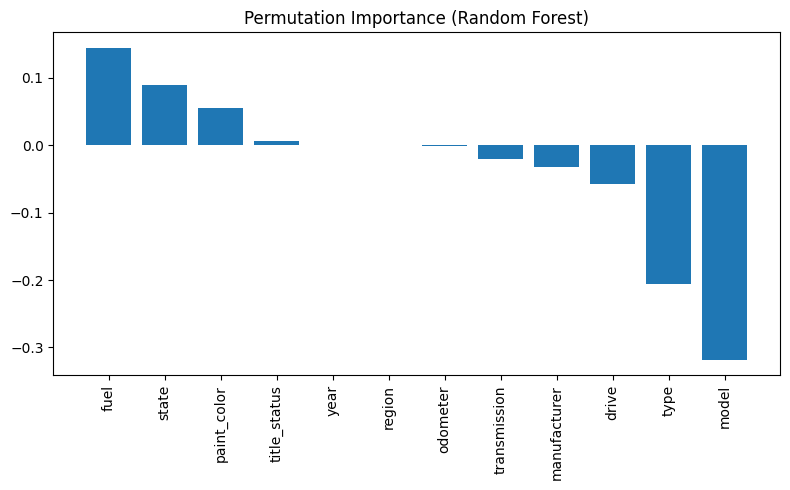

fuel: 0.144475
state: 0.090081
paint_color: 0.054631
title_status: 0.006096
year: 0.000000
region: 0.000000
odometer: -0.000995
transmission: -0.019666
manufacturer: -0.031742
drive: -0.056729


In [26]:
# Step 13 — Permutation Importance (robust, single-process + subsample)

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Optional: evaluate on a subsample for speed
X_eval = X_test.sample(n=min(60000, len(X_test)), random_state=42)
y_eval = y_test.loc[X_eval.index]

# Run permutation importance (single process to avoid pickling issues)
result = permutation_importance(
    rf_final, X_eval, y_eval,
    n_repeats=5, random_state=42, n_jobs=1
)

# Sort and plot
importances = result.importances_mean
indices = importances.argsort()[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_eval.columns[indices], rotation=90)
plt.title("Permutation Importance (Random Forest)")
plt.tight_layout()
plt.show()

# Print top features
for i in indices[:10]:
    print(f"{X_eval.columns[i]}: {importances[i]:.6f}")
